**NOTE: if you don't care about the inner workings and just want to train a model, skip (or shrink) the first codebase cell.**

In [24]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt

import os
from glob import glob
from random import shuffle
import copy
import random
from tqdm import tqdm
import missingno as msno # For visualization on missing values.

import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from imblearn.over_sampling import SMOTE 

import lightgbm as lgb

import matplotlib.pyplot as plt


In [2]:
class DataLoader:
    def __init__(self, file_type='.csv'):
        folder = {'.csv':'csv_files', '.parquet':'parquet_files'}
        self.dataPath = dataPath = f"/kaggle/input/home-credit-credit-risk-model-stability/{folder[file_type]}"
        self.file_type=file_type
        return    
    
    def set_dtypes(self, df):
        # reduce size of df and standardize
        for col in df.columns:
            # last letter of column name will help you determine the type
            if col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float32).alias(col))
            elif col[-1] =="D" or col =="date_decision":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
                
            # convert strings to categorical
            if df[col].dtype in [pl.String]:
                df = df.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
                
            # standardize all numeric to Float32
            elif df[col].dtype in [pl.Float64, pl.Int64, pl.Boolean]:
                df = df.with_columns(pl.col(col).cast(pl.Float32).alias(col))
        return df
    
    
    def handle_dates(self, df):
        # modified from code created by Farukcan Saglam for this competition
        for col in df.columns:
            if col[0].islower and col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
        df = df.drop("date_decision",)
        return df
    
       
    def load_single_df(self, name, depth=0, features=None, feature_types=None, description=None):
        print(f"Loading {name}")
        results = []
        split = 'train'
        # FIRST, load all files which match name
        # load all partitions
        df_list = []
        for file in glob(f"{self.dataPath}/{split}/{split}_{name}*"):
            if self.file_type == '.parquet':
                df = pl.read_parquet(file, infer_schema_length=60000).pipe(self.set_dtypes)
            else:
                df = pl.read_csv(file, infer_schema_length=60000).pipe(self.set_dtypes)
            df_list.append(df)
            
        # special case: treating the tax registries as partitions of same file
        if name == "tax_registry":
            name_map ={"M":"employerM", "A":"taxdeductionA","D":"processdateD"}
            for i in range(len(df_list)):
                # standardize their names to allow concat
                standard_cols = [name_map[c[-1]] if c not in ['case_id', "num_group1"] else c for c in df_list[i].columns]
                df_list[i].columns = standard_cols
                df_list[i] = df_list[i].select(sorted(standard_cols))
            
        # standardize dtypes; if they disagree, it inferred an all-NaN float col as String
        if len(df_list)>1:
            for i, dtypes in enumerate(zip(*[df.dtypes for df in df_list])):
                if len(set(dtypes)) > 1: # different dtypes
                    print(f"dtype mismatch: {name}, {split}, column {df_list[0].columns[i]}, dtypes: {dtypes}. Cast all to Float32.")
                    for j in range(len(df_list)):
                        col = df_list[j].columns[i]
                        df_list[j] = df_list[j].with_columns(pl.col(col).cast(pl.Float32).alias(col))
            # combine partitions    
        df = pl.concat(df_list, how="vertical_relaxed")

        # NEXT, infer features to select if not explicitly specified

        if name != 'base': 
            features = [f for f in df.columns]
            features.append('case_id')
        
        else:
            features = ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']
                # select group features
            for g in range(depth):
                features.append(f'num_group{g+1}')
            features.append('case_id')

        df = df.select(list(set(features)))
        # rename group features
        for g in range(depth):
            alias = f"{name}_group{g+1}S"
            df = df.rename({f'num_group{g+1}':alias})


        # FINALLY, if depth > 0, aggregate
        if depth > 0:
            # determine the aggregations to perform
            # NB currently, this lumps dates in with categories, and returns the most frequent (vs max)
            num_agg_list = [pl.col(f).max().name.prefix("max_") for f in df.select(cs.numeric()).drop('case_id').columns]
            cat_agg_list = [pl.col(f).drop_nulls().mode().first().name.prefix("mostfreq_") for f in df.select(~cs.numeric()).columns]
            # groupby and aggregate
            df = df.group_by("case_id").agg(num_agg_list+cat_agg_list)
        try:
            df = pl.concat([df, non_agg_features], how='horizontal')
        except:
            pass # no non_agg_features
        results.append(df)
        # now repeat for 'test' or submit df
        return results
    
    def load_dfs(self, descriptions):

        train = {}
        train_base = None  
    
        for name in tqdm(descriptions):
        # Load DataFrame for each description
            df = self.load_single_df(**descriptions[name])

            if isinstance(df, list):
                df = pl.concat(df)  
        
            train[name] = df      

            if name == 'base':
                train_base = df
                print("Base DataFrame:", train_base)

        for name, df in train.items():
            if name != 'base':  
                train_base = train_base.join(df, on='case_id', how='left')
                print(f"Joined {name} to base")    

        train_base = self.handle_dates(train_base)    
        print('Loading and joining complete')
        
        return train_base, df

In [3]:
dataset = {
    "base":{
        "description": "links case_id to WEEK_NUM and target",
        "name":"base",
    },
    "static_0":{
        "description":"contains transaction history for each case_id (late payments, total debt, etc)",
        "name":"static_0",
    },
    "static_cb":{
        "description":"data from an external cb: demographic data, risk assessment, number of credit checks",
        "name":"static_cb",
    },
#     "applprev_1":{
#         "description":"internal/1.3GB/70%: info from clients previous loan applications",
#         "name":"applprev_1",
#         "depth":1,
#     },
    "other_1":{
        "description":"internal/0.002GB/100%: transaction history of client debit account",
        "name":"other_1",
        "depth":1,
    },
    "tax_registry":{
        "description":"info from all three tax registry providers combined, approx 0.3GB",
        "name":"tax_registry",
        "depth":1,
    },
#     "credit_bureau_a_1":{
#         "description":"external/3.2GB/35%: detailed history for client loan contracts",
#         "name":"credit_bureau_a_1",
#         "depth":1,
#     },
#     "credit_bureau_b_1":{
#         "description":"external/0.02GB/80%: detailed history for client loan contracts",
#         "name":"credit_bureau_b_1",
#         "depth":1,
#     },
    "deposit_1":{
        "description":"internal/0.005GB/90%: deposit account history",
        "name":"deposit_1",
        "depth":1,
    },
    "person_1":{
        "description":" internal/0.5GB/55%: demographic information: zip code, marital status, gender etc (all hashed)",
        "name":"person_1",
#         "features":["mainoccupationinc_384A", "incometype_1044T"],
        "depth":1,
    },
    "debitcard_1":{
        "description":"internal/0.004GB/55%: information about debit card usage",
        "name":"debitcard_1",
        "depth":1,
    },
    "applprev_2":{
        "description":"internal/0.45GB/81%: info about card blockage on previous credit accounts",
        "name":"applprev_2",
        "depth":2,
    },
    "person_2":{
        "description":"internal/0.1GB/75%: info about clients contacts and their employment",
        "name":"person_2",
        "depth":2,
    },
#     "credit_bureau_a_2":{
#         "description":"external/15.6GB/66%: info about collateral and payment dates",
#         "name":"credit_bureau_a_2",
#         "depth":2,
#     },
    "credit_bureau_b_2":{
        "description":"external/0.04GB/100%: num and value of overdue payments",
        "name":"credit_bureau_b_2",
        "features":["pmts_pmtsoverdue_635A","pmts_dpdvalue_108P"],
        "depth":2,
    }
}


In [4]:
data = DataLoader()
base, dataframes = data.load_dfs(dataset)

  0%|          | 0/11 [00:00<?, ?it/s]

Loading base


  9%|▉         | 1/11 [00:00<00:09,  1.01it/s]

Base DataFrame: shape: (1_526_659, 5)
┌───────────────┬────────────┬──────────┬──────────┬────────┐
│ date_decision ┆ case_id    ┆ MONTH    ┆ WEEK_NUM ┆ target │
│ ---           ┆ ---        ┆ ---      ┆ ---      ┆ ---    │
│ date          ┆ f32        ┆ f32      ┆ f32      ┆ f32    │
╞═══════════════╪════════════╪══════════╪══════════╪════════╡
│ 2019-01-03    ┆ 0.0        ┆ 201901.0 ┆ 0.0      ┆ 0.0    │
│ 2019-01-03    ┆ 1.0        ┆ 201901.0 ┆ 0.0      ┆ 0.0    │
│ 2019-01-04    ┆ 2.0        ┆ 201901.0 ┆ 0.0      ┆ 0.0    │
│ 2019-01-03    ┆ 3.0        ┆ 201901.0 ┆ 0.0      ┆ 0.0    │
│ 2019-01-04    ┆ 4.0        ┆ 201901.0 ┆ 0.0      ┆ 1.0    │
│ …             ┆ …          ┆ …        ┆ …        ┆ …      │
│ 2020-10-05    ┆ 2.70345e6  ┆ 202010.0 ┆ 91.0     ┆ 0.0    │
│ 2020-10-05    ┆ 2.703451e6 ┆ 202010.0 ┆ 91.0     ┆ 0.0    │
│ 2020-10-05    ┆ 2.703452e6 ┆ 202010.0 ┆ 91.0     ┆ 0.0    │
│ 2020-10-05    ┆ 2.703453e6 ┆ 202010.0 ┆ 91.0     ┆ 0.0    │
│ 2020-10-05    ┆ 2.703454e6 ┆ 2

Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
 18%|█▊        | 2/11 [00:17<01:30, 10.07s/it]

Loading static_cb


 36%|███▋      | 4/11 [00:21<00:30,  4.35s/it]

Loading other_1
Loading tax_registry


 45%|████▌     | 5/11 [00:29<00:34,  5.67s/it]

Loading deposit_1


 55%|█████▍    | 6/11 [00:29<00:19,  3.93s/it]

Loading person_1


 64%|██████▎   | 7/11 [02:06<02:16, 34.20s/it]

Loading debitcard_1


 73%|███████▎  | 8/11 [02:06<01:10, 23.46s/it]

Loading applprev_2


 82%|████████▏ | 9/11 [02:18<00:39, 19.88s/it]

Loading person_2


 91%|█████████ | 10/11 [02:36<00:19, 19.22s/it]

Loading credit_bureau_b_2


100%|██████████| 11/11 [02:37<00:00, 14.29s/it]


Joined static_0 to base
Joined static_cb to base
Joined other_1 to base
Joined tax_registry to base
Joined deposit_1 to base
Joined person_1 to base
Joined debitcard_1 to base
Joined applprev_2 to base
Joined person_2 to base
Joined credit_bureau_b_2 to base
Loading and joining complete


Once the dataset has been loaded, we want to filter out the variables that are categorical, with the following objectives.
a) Perform one hot encoding. Which we later was discarded for the EDA as  we were execeding the compute time.
b) Filter out the variables related to 'gender' or 'sex' to evaluate if there is bias in the data.


In [5]:
# Listhold the categroical variables that need to be hot encoded.
feats_to_conv = []
#  List to hold the variables that are related to Gender.
gender_feats = []

# Getting the columns from the dataframe.
feats = base.columns

# Appending the features that match the criteria.
feats_to_conv.append([f for f in feats if f[-1] in ("M","L")])
feats_l = feats_to_conv[0]
# Dropping WEEK_NUM from list of variables to convert.
feats_l.pop(0)

#Iterating to accumulate the variables related to gender.
gender_feats.append([f for f in feats_l if 'gender' in f])
gender_feats.append([f for f in feats_l if 'sex' in f])


In [6]:
features = ['mostfreq_gender_992L', 'mostfreq_sex_738L']

# Filtering to include only categorical columns plus the 'case_id' column:
categorical_data = base.select([
    pl.col(col).alias(col) for col in base.columns if col in features or col == 'case_id'
])

# Filtering to include only floats  columns plus the 'case_id', 'target_id' column:
float_data = base.select([
    pl.col(col).alias(col) for col in base.columns if base[col].dtype == pl.Float32 or col == 'case_id' or col == 'target_id'
])

# Converting from polars to Pandas.
categorical_df = categorical_data.to_pandas()
float_df = float_data.to_pandas()

# One Hot Encoding.
one_hot_encoded_data = pd.get_dummies(categorical_df, columns = features)

# Converting case_id as integer.
one_hot_encoded_data['case_id'] = one_hot_encoded_data['case_id'].astype(int)
float_df['case_id'] = float_df['case_id'].astype(int)

# Setting index.
categorical_df = one_hot_encoded_data.set_index('case_id')
float_df = float_df.set_index('case_id')

# Buidding a dataframe with gender included and all float data.
base_df_w_gender = float_df.merge(categorical_df, how = 'inner', on ='case_id')

# Creating a correlation matrix for Gender.
base_df_w_gender_cor = base_df_w_gender.corr()



In [7]:
base_df_w_gender

,MONTH,WEEK_NUM,target,clientscnt_533L,disbursedcredamount_1113A,numinstpaidearly5d_1087L,pctinstlsallpaidlate1d_3546856L,numinsttopaygr_769L,numinstlswithoutdpd_562L,clientscnt_136L,...,mostfreq_empls_employedfrom_796D,max_credit_bureau_b_2_group2S,max_pmts_dpdvalue_108P,max_credit_bureau_b_2_group1S,max_pmts_pmtsoverdue_635A,mostfreq_pmts_date_1107D,mostfreq_gender_992L_F,mostfreq_gender_992L_M,mostfreq_sex_738L_F,mostfreq_sex_738L_M
case_id,,,,,,,,,,,,,,,,,,,,,
0,201901.0,0.0,0.0,0.0,30000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
1,201901.0,0.0,0.0,0.0,19999.800781,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True
2,201901.0,0.0,0.0,0.0,78000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
3,201901.0,0.0,0.0,0.0,40000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
4,201901.0,0.0,1.0,0.0,44000.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703450,202010.0,91.0,0.0,0.0,30000.000000,11.0,0.03540,0.0,117.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
2703451,202010.0,91.0,0.0,0.0,40739.539062,0.0,0.01351,11.0,76.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False
2703452,202010.0,91.0,0.0,0.0,60000.000000,3.0,0.33333,0.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True


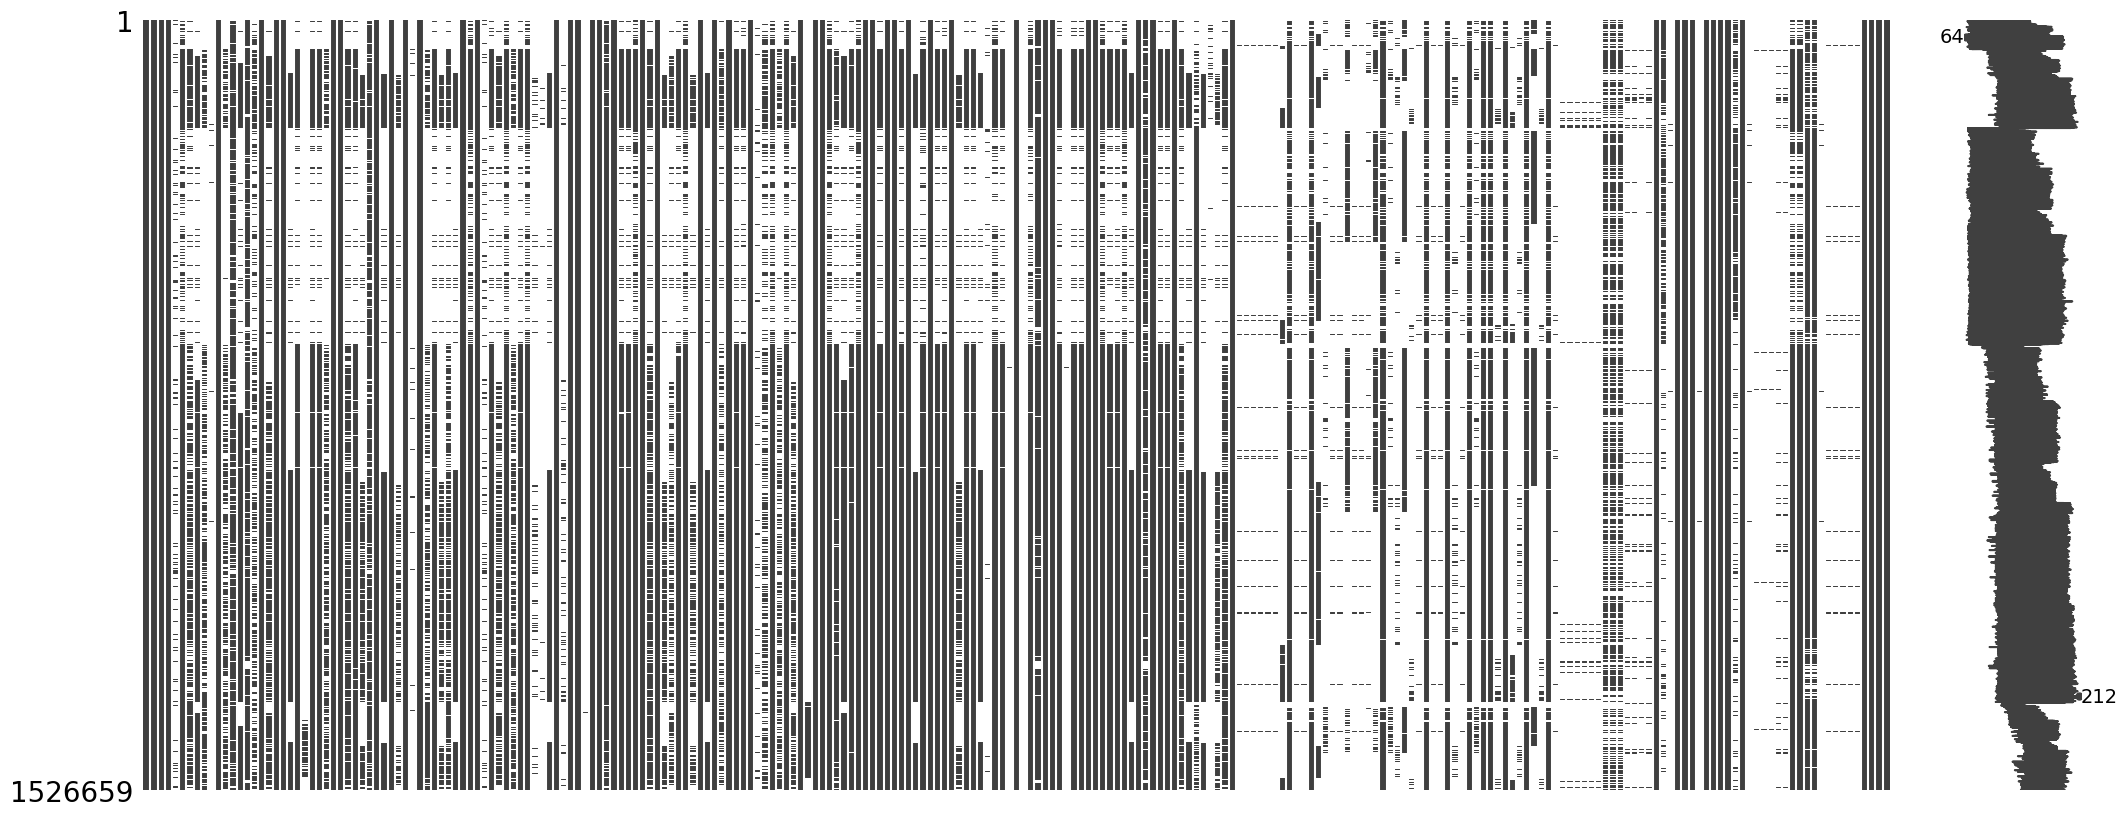

In [66]:
msno.matrix(base_df_w_gender)
plt.show()
    

In [14]:
base_df_w_gender_cor = base_df_w_gender.corr()

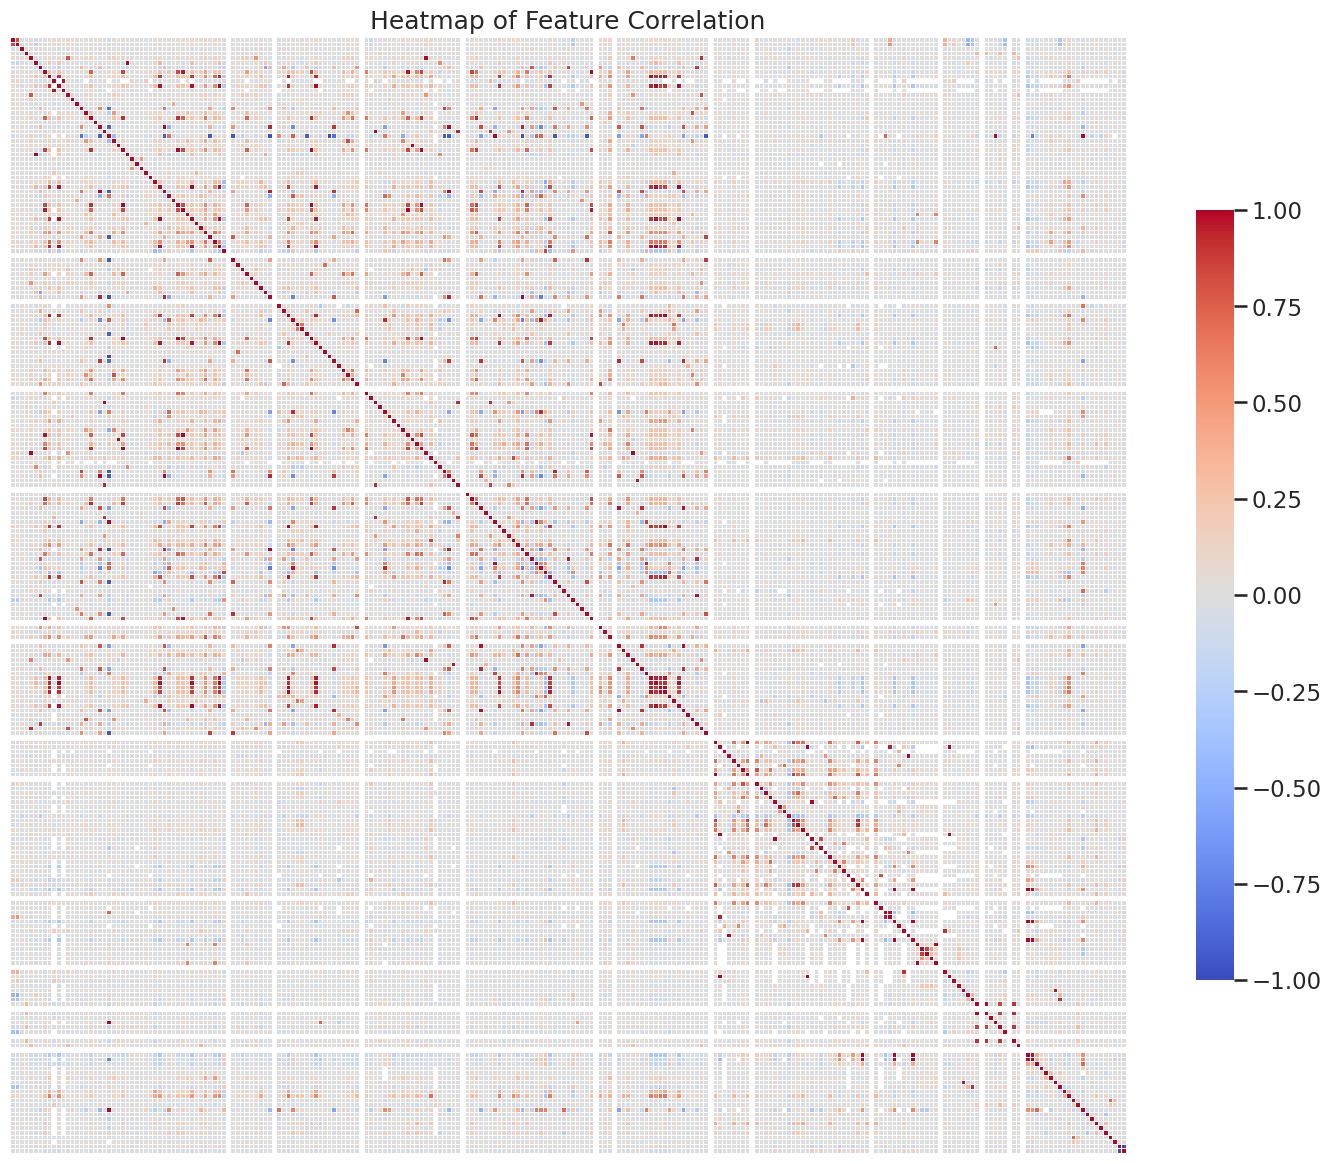

In [15]:
# Heatmap for the  Feature Correlation.

# Set up the matplotlib figure
plt.figure(figsize=(18, 20))

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(base_df_w_gender_cor, annot=False, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Add titles and labels as necessary
plt.title('Heatmap of Feature Correlation')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

plt.show()

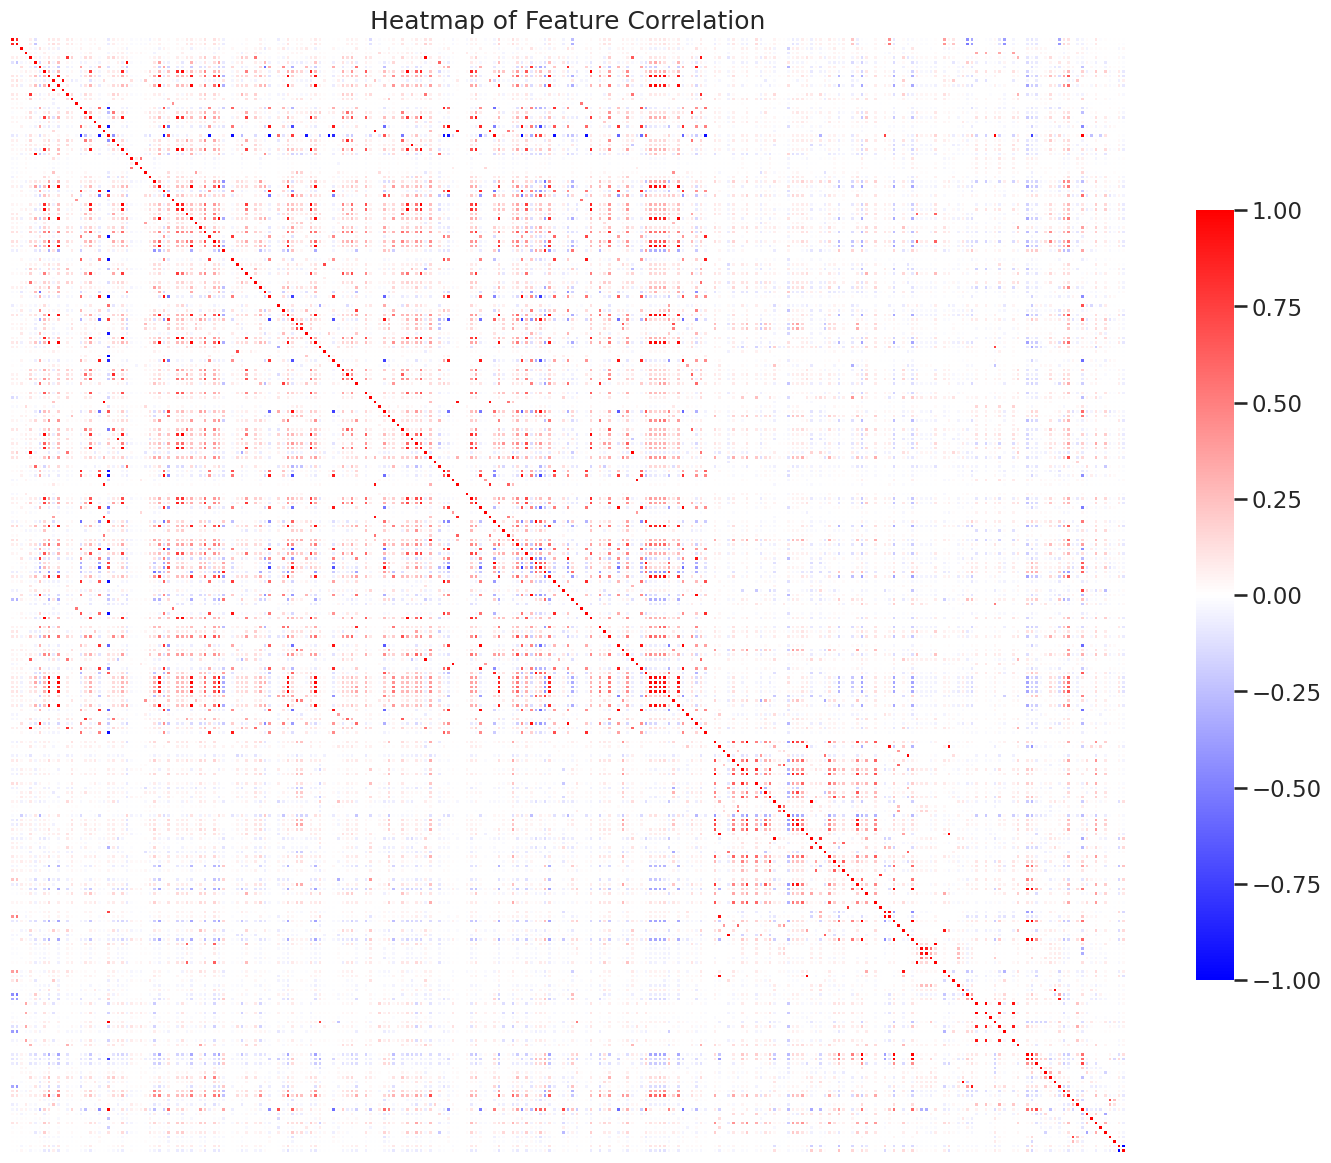

In [16]:
plt.figure(figsize=(18, 20))

# Defining the colors for the  heatmap
colors = ["blue", "white", "red"]  
cmap = sns.blend_palette(colors, as_cmap=True)

ax = sns.heatmap(base_df_w_gender_cor, annot=False, fmt=".2f", cmap=cmap,
                 square=True, linewidths=.1,cbar_kws={"shrink": .5}, 
                 vmin=-1, vmax=1)  

# Remove the X and Y tick labels and marks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Add title
plt.title('Heatmap of Feature Correlation')

# Display the heatmap
plt.show()

In [17]:
base_df = base.to_pandas()

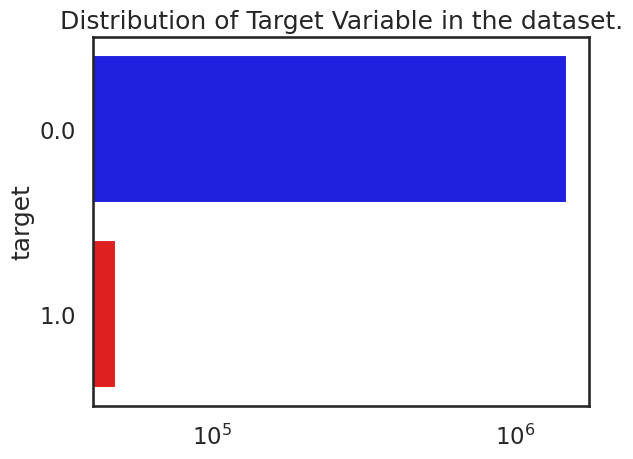

In [18]:
# Set the theme
sns.set_theme(style="white", context="talk")

# Define the color palette
palette_col = {0: 'blue', 1: 'red'}

# Create plot
ax = sns.countplot(y='target',palette=palette_col, data = base_df)

# Set the title
ax.set_title('Distribution of Target Variable in the dataset.')

# Set the scale to log
ax.set_xscale('log')

ax.set_xlabel('')

plt.show()

In [26]:
# Extract the correlations of 'target' with all other features
target_corr = base_df_w_gender_cor['target'].drop('target')  # Drop self-correlation
target_corr = target_corr.sort_values(ascending=False).head(10)
target_corr_neg = base_df_w_gender_cor['target'].drop('target')
target_corr_neg = target_corr_neg.sort_values(ascending=True).head(10)


corr_df = target_corr.reset_index()
corr_df_neg = target_corr_neg.reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df_neg.columns = ['Feature', 'Correlation']
corr_df_neg['Correlation'] = corr_df_neg['Correlation'].abs()

In [30]:
def chart_df(df, s_order, color, title):
    
    
    # Define the base chart
    base = alt.Chart(df).encode(
                                alt.X('Feature:N',axis=alt.Axis(
                                                                title='Features', labelAngle=-45, labelFont='Courier', titleFont='Courier', labelFontSize=16, titleFontSize=16)
                                                                             ).sort(s_order),
                                alt.Y('Correlation:Q',axis=alt.Axis(
                                                                title='', labelFont='Courier', titleFont='Courier', labelFontSize=16, ticks=False, grid=False, labels=False)
                                                                    ),
                                text=alt.Text('Correlation:Q', format='.2f'),
                                tooltip=['Feature', 'Correlation']
                                )

    # Create bar chart
    chart_bar = base.mark_bar().encode(
                                        color=alt.value(color)
                                        )

    # Create text chart
    chart_text = base.mark_text(align='center', baseline='bottom', dy=-10, fontSize=12).encode(
                                                                                            alt.X('Feature:N').sort(s_order), 
                                                                                            text=alt.Text('Correlation:Q', format='.2f'),
                                                                                            color=alt.value('black')
                                                                                            )
    # Combine bar and text charts
    corr_chart = chart_bar + chart_text

    corr_chart = corr_chart.properties(
        height=400,
        width=400,
        title=title
                                    )

    return corr_chart

In [31]:
pos_corr = chart_df(corr_df, '-y', 'red', title = 'Correlation of "target" to other features')
neg_corr = chart_df(corr_df_neg, '-y', 'blue', title = 'Correlation of "target" to other features')


pos_corr | neg_corr

alt.HConcatChart(...)

In [23]:
# import altair as alt

# df = corr_df


# base = alt.Chart(df).encode(
#                                         alt.X('Feature', axis=alt.Axis(title='Features', labelAngle = -45, labelFont='Courier', titleFont='Courier', labelFontSize=16, titleFontSize=16)).sort('-y'),                                        
#                                         alt.Y('Correlation', axis=alt.Axis(title='', labelFont='Courier', titleFont='Courier', labelFontSize=16, ticks=False, grid=False, labels = False)),
#                                         text = alt.Text('Correlation',  format='.2f'),
#                                         tooltip=['Feature', 'Correlation']
#                                             )
# chart_bar = base.mark_bar().encode(
#                                     color = alt.value('red'))
# chart_text = base.mark_text(align='center', baseline='bottom', fontSize=12).encode(
#                                     color = alt.value('black'))


# corr_chart = chart_bar + chart_text

# corr_chart.properties(height=400, width= 400)

In [32]:
# For male

def corr_matrix_gen(df, feature, neg=False):
    
    target_corr = df[feature].drop(feature)
    target_corr = target_corr.reset_index()
    target_corr.columns = ['Feature', 'Correlation']
    
    if neg == True:
        
        df_corr = target_corr.sort_values(by = 'Correlation', ascending = True).head(10)
        df_corr['Correlation'] = df_corr['Correlation'].abs()
        
    else:
        df_corr = target_corr.sort_values(by = 'Correlation', ascending = False).head(10)
    
    return df_corr

In [33]:
male_pos_corr = corr_matrix_gen(base_df_w_gender_cor, 'mostfreq_gender_992L_M', False)
male_neg_corr = corr_matrix_gen(base_df_w_gender_cor, 'mostfreq_gender_992L_M', True)
female_pos_corr = corr_matrix_gen(base_df_w_gender_cor, 'mostfreq_gender_992L_F', False)
female_neg_corr = corr_matrix_gen(base_df_w_gender_cor, 'mostfreq_gender_992L_F', True)

In [34]:
pos_corr_male = chart_df(male_pos_corr, '-y', 'red', title = 'Correlation of "Male Gender" to other features')
neg_corr_male = chart_df(male_neg_corr, '-y', 'blue', title = 'Correlation of "Male Gender" to other features')

pos_corr_male | neg_corr_male

alt.HConcatChart(...)

In [35]:
pos_corr_female = chart_df(female_pos_corr, '-y', 'red', title = 'Correlation of "Female Gender" to other features' )
neg_corr_female = chart_df(female_neg_corr, '-y', 'blue', title = 'Correlation of "Female Gender" to other features')

pos_corr_female | neg_corr_female

alt.HConcatChart(...)

In [ ]:
## Auxiliary Functions for Feature Selection.

def summary(df):
    ''' This function returns a summary of the quality of the data'''
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    # Total of row entries.
    summ['#total'] = df.shape[0]
    # Number of missing values.
    summ['#missing'] = df.isnull().sum().values 
    # Proportion of missing values with respect the number of entries.
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    # Number of unique values.
    summ['#unique'] = df.nunique().values
    # Number of distinct values . To understand  the spread of the values.
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    #  Transposing the data frame to get max and min values.
    desc = pd.DataFrame(df.describe(include='all').transpose())
    # Calculating the min values.
    summ['min'] = desc['min'].values
    # Calculating the max values.
    summ['max'] = desc['max'].values    
    # Calculating the average values
    summ['mean'] = desc['mean'].values    
    
    
#     summ['Class_0_count'] =  0
#     summ['Class_1_count'] = 0
    
    
# #     This portion of the code is to  generate counts grouped per target class.
    
#     grpd_df = df.groupby('target').describe(include='all') 
    
#     for column in df.columns:
#         if column != 'target':  # Exclude the 'target' column itself
#             summ.loc[column, 'Class_0_count'] = grpd_df[column]['count'][0]
#             summ.loc[column, 'Class_0_mean'] = grpd_df[column]['mean'][0]
            
#             summ.loc[column, 'Class_1_count'] = grpd_df[column]['count'][1]
#             summ.loc[column, 'Class_1_mean'] = grpd_df[column]['mean'][1]
            
            
#     summ['imbalance_Prop'] =  summ['Class_1_count'] / summ['Class_0_count']  
            
    
    return summ

EDA Data features 

In [135]:
import pandas as pd
df = pd.read_csv('/kaggle/input/home-credit-credit-risk-model-stability/csv_files/train/train_static_0_1.csv')
df_desc = pd.read_csv('/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv')
df_desc

Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.


,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.
2,addres_district_368M,District of the person's address.
3,addres_role_871L,Role of person's address.
4,addres_zip_823M,Zip code of the address.
...,...,...
460,totinstallast1m_4525188A,Total amount of monthly instalments paid in th...
461,twobodfilling_608L,Type of application process.
462,type_25L,Contact type of a person.
463,typesuite_864L,Persons accompanying the client during the loa...


In [136]:
# vars_ = df.columns
vars_2 = ['max_person_2_group']

In [139]:
# Filter the DataFrame to only include rows where 'Variable' matches the list
filtered_df = df_desc[df_desc['Variable'].isin(vars_2)]
filtered_df
# filtered_df.to_csv('/static.csv')

,Variable,Description


In [142]:
base.head()

case_id,MONTH,WEEK_NUM,target,numinstmatpaidtearly2d_4499204L,applicationscnt_1086L,numinstpaidearly5dest_4493211L,numinstpaidearly_338L,commnoinclast6m_3546845L,lastactivateddate_801D,numinstunpaidmaxest_4493212L,lastrejectreason_759M,lastrejectcommodtypec_5251769M,avgdbddpdlast24m_3658932P,numinstpaidearly5dobd_4499205L,paytype1st_925L,datelastunpaid_3546854D,numinstlallpaidearly3d_817L,homephncnt_628L,lastapprcredamount_781A,clientscnt_533L,downpmt_116A,numinsttopaygrest_4493213L,numinsttopaygr_769L,numrejects9m_859L,payvacationpostpone_4187118D,maxdpdlast9m_1059P,mastercontrexist_109L,maxdpdfrom6mto36m_3546853P,numinstpaidlastcontr_4325080L,datelastinstal40dpd_247D,avgpmtlast12m_4525200A,maxdpdtolerance_374P,isbidproductrequest_292L,maxdpdlast6m_474P,avgdbddpdlast3m_4187120P,lastotherlnsexpense_631A,…,mostfreq_empl_industry_691L,mostfreq_empladdr_district_926M,mostfreq_registaddr_zipcode_184M,mostfreq_role_993L,mostfreq_birthdate_87D,mostfreq_incometype_1044T,mostfreq_gender_992L,mostfreq_sex_738L,mostfreq_type_25L,mostfreq_empl_employedtotal_800L,mostfreq_housingtype_772L,mostfreq_empl_employedfrom_271D,max_last180dayaveragebalance_704A,max_debitcard_1_group1S,max_last180dayturnover_1134A,max_last30dayturnover_651A,mostfreq_openingdate_857D,max_applprev_2_group2S,max_applprev_2_group1S,mostfreq_conts_type_509L,mostfreq_cacccardblochreas_147M,mostfreq_credacc_cards_status_52L,max_person_2_group2S,max_person_2_group1S,mostfreq_conts_role_79M,mostfreq_addres_zip_823M,mostfreq_empls_employedfrom_796D,mostfreq_empls_employer_name_740M,mostfreq_empls_economicalst_849M,mostfreq_addres_district_368M,mostfreq_relatedpersons_role_762T,mostfreq_addres_role_871L,max_credit_bureau_b_2_group2S,max_pmts_pmtsoverdue_635A,max_pmts_dpdvalue_108P,max_credit_bureau_b_2_group1S,mostfreq_pmts_date_1107D
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,cat,cat,f32,f32,cat,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,cat,cat,cat,cat,f32,cat,cat,cat,cat,cat,cat,f32,f32,f32,f32,f32,f32,f32,f32,cat,cat,cat,f32,f32,cat,cat,f32,cat,cat,cat,cat,cat,f32,f32,f32,f32,f32
0.0,201901.0,0.0,0.0,null,0.0,null,null,0.0,null,null,"""a55475b1""","""a55475b1""",null,null,"""OTHER""",null,null,0.0,null,0.0,0.0,null,null,0.0,null,0.0,0.0,0.0,null,null,null,0.0,null,0.0,null,null,…,"""OTHER""","""a55475b1""","""a55475b1""",null,null,"""SALARIED_GOVT""",null,"""F""","""PHONE""","""MORE_FIVE""",null,-475.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1.0,201901.0,0.0,0.0,null,0.0,null,null,0.0,null,null,"""a55475b1""","""a55475b1""",null,null,"""OTHER""",null,null,0.0,null,0.0,0.0,null,null,0.0,null,0.0,0.0,0.0,null,null,null,0.0,null,0.0,null,null,…,"""OTHER""","""a55475b1""","""a55475b1""",null,null,"""SALARIED_GOVT""",null,"""M""","""PHONE""","""MORE_FIVE""",null,-3718.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2.0,201901.0,0.0,0.0,null,0.0,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,"""OTHER""",null,null,1.0,null,0.0,0.0,null,null,0.0,null,0.0,0.0,null,null,null,null,0.0,null,0.0,null,null,…,"""OTHER""","""a55475b1""","""a55475b1""",null,null,"""EMPLOYED""",null,"""F""","""PRIMARY_MOBILE…","""MORE_FIVE""",null,-3245.0,null,null,null,null,null,1.0,1.0,"""PRIMARY_MOBILE…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3.0,201901.0,0.0,0.0,null,0.0,null,null,0.0,null,null,"""P94_109_143""","""a55475b1""",null,null,"""OTHER""",null,null,0.0,null,0.0,0.0,null,null,1.0,null,0.0,0.0,0.0,null,null,null,0.0,null,0.0,null,null,…,"""OTHER""","""a55475b1""","""a55475b1""",null,null,"""EMPLOYED""",null,"""F""","""PHONE""","""MORE_FIVE""",null,-233.0,null,null,null,null,null,2.0,0.0,"""PRIMARY_EMAIL""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4.0,201901.0,0.0,1.0,null,0.0,null,nu

In [145]:
base['WEEK_NUM'].unique()

WEEK_NUM
f32
0.0
1.0
2.0
3.0
4.0
…
87.0
88.0
89.0


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


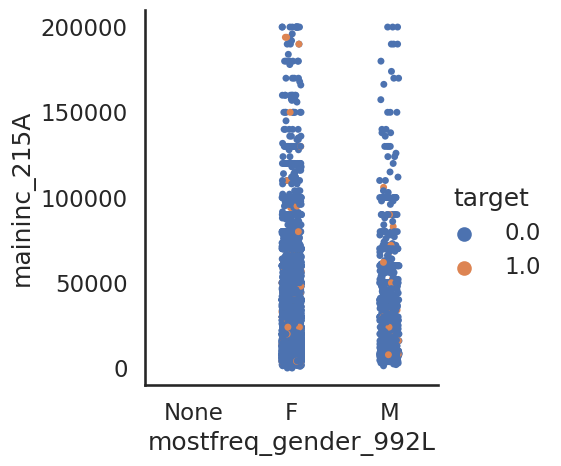

In [152]:

sns.catplot(
    data=base, x="mostfreq_gender_992L", y="maininc_215A", hue="target",
    native_scale=True, zorder=1
)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


<Axes: xlabel='mostfreq_gender_992L', ylabel='maininc_215A'>

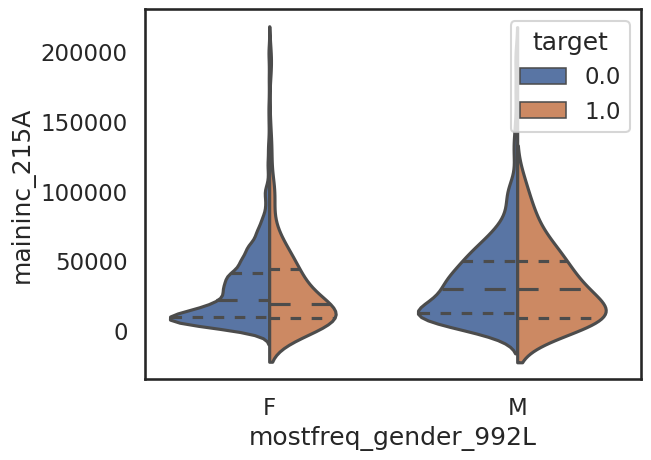

In [156]:
base_df = base.to_pandas()

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=base_df, x="mostfreq_gender_992L", y="maininc_215A", hue="target",
               split=True, inner="quart")

<Axes: xlabel='WEEK_NUM', ylabel='maininc_215A'>

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


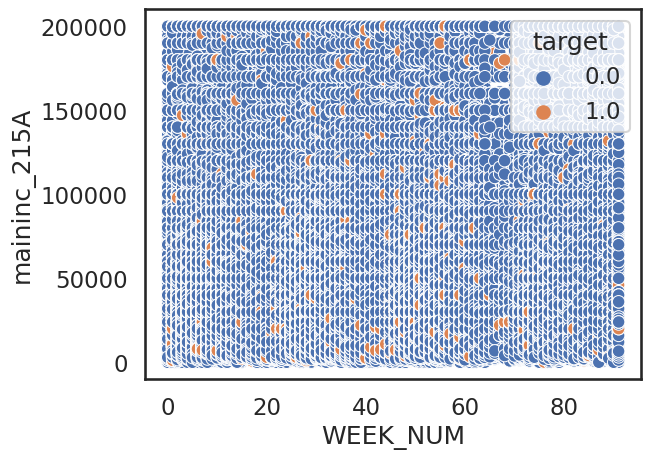

In [158]:
sns.scatterplot(x="WEEK_NUM", y="maininc_215A",
                hue="target", data = base_df)